In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Seed Value : ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Seed Value :  999


In [5]:
dataroot = "/home/piai/Bus/NFC"

# dataloader에서 사용할 쓰레드 수
workers = 2

batch_size = 32
image_size = 64

# 이미지의 채널 수 (RGB 이미지 : 3, 흑백 이미지 : 1)
nc = 3
# 생성자의 입력값 크기
nz = 100
# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64
# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

num_epochs = 3000

lr = 0.0002

# Adam 옵티마이저 : beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 수 (CPU를 사용해야 하는 경우 : 0으로 설정)
ngpu = 1

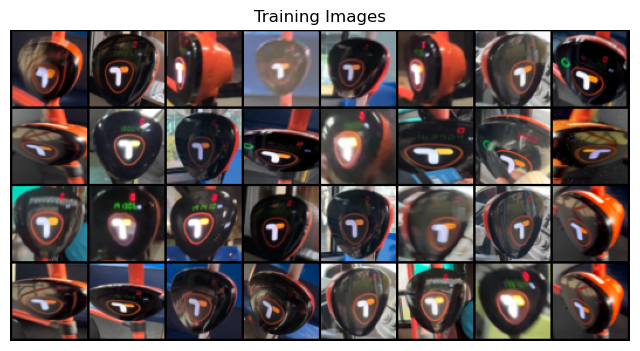

In [6]:
dataroot = "/home/piai/Bus/NFC"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...
[0/3000][0/4]	Loss_D: 1.5139	Loss_G: 6.7296	D(x): 0.6535	D(G(z)): 0.5644 / 0.0014
[1/3000][0/4]	Loss_D: 0.2502	Loss_G: 6.3576	D(x): 0.9272	D(G(z)): 0.1298 / 0.0020
[2/3000][0/4]	Loss_D: 0.1451	Loss_G: 6.0499	D(x): 0.9214	D(G(z)): 0.0470 / 0.0032
[3/3000][0/4]	Loss_D: 0.1080	Loss_G: 8.3631	D(x): 0.9916	D(G(z)): 0.0870 / 0.0003
[4/3000][0/4]	Loss_D: 0.2153	Loss_G: 12.2117	D(x): 0.9772	D(G(z)): 0.1573 / 0.0000
[5/3000][0/4]	Loss_D: 0.0795	Loss_G: 9.7189	D(x): 0.9869	D(G(z)): 0.0621 / 0.0001
[6/3000][0/4]	Loss_D: 0.1311	Loss_G: 11.9698	D(x): 0.9702	D(G(z)): 0.0868 / 0.0000
[7/3000][0/4]	Loss_D: 0.0281	Loss_G: 14.9738	D(x): 0.9728	D(G(z)): 0.0001 / 0.0000
[8/3000][0/4]	Loss_D: 0.0773	Loss_G: 12.7504	D(x): 0.9359	D(G(z)): 0.0004 / 0.0000
[9/3000][0/4]	Loss_D: 0.0304	Loss_G: 14.2187	D(x): 0.9713	D(G(z)): 0.0002 / 0.0000
[10/3000][0/4]	Loss_D: 0.0197	Loss_G: 9.9162	D(x): 0.9911	D(G(z)): 0.0105 / 0.0001
[11/3000][0/4]	Loss_D: 0.0211	Loss_G: 9.1152	D(x): 0.9872	D(G(z)):

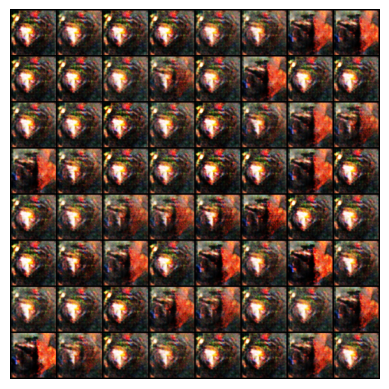

In [13]:
if not os.path.isdir("./torch_results"):
  os.makedirs("./torch_results")

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Discriminator 학습 단계
        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        label = torch.full((b_size,), real_label,dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)

        errD_real = criterion(output, label)
        errD_real.backward()
        
        D_x = output.mean().item()


        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        # Generator 학습 단계
        netG.zero_grad()

        label.fill_(real_label)
        output = netD(fake).view(-1)

        errG = criterion(output, label)
        errG.backward()
        
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    plt.imshow(np.transpose(img_list[-1],(1,2,0)))android demo app pytorch
    plt.axis("off")
    
    plt.savefig("./nfc_results/gan_nebula%03d.png" % (epoch))

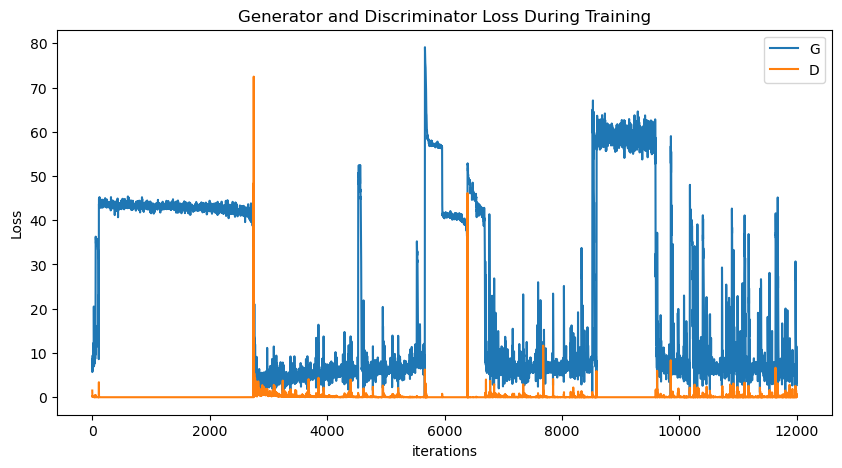

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
img_list

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5431,  ..., 0.5715, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.5613,  ..., 0.5892, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5379,  ..., 0.5759, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.5775,  ..., 0.5832, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4900,  ...,

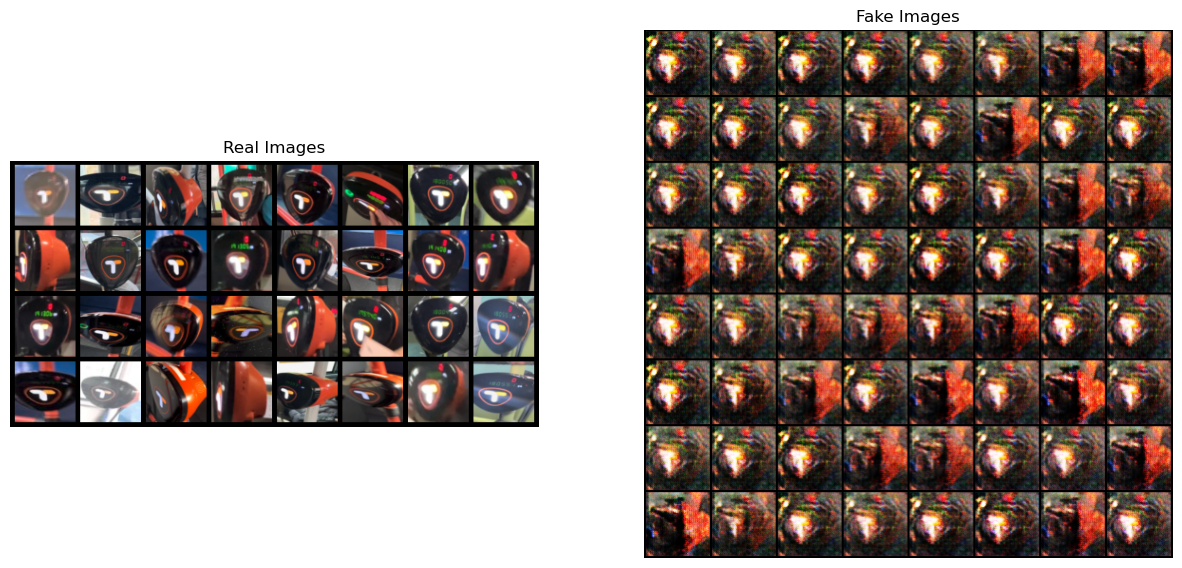

In [15]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다￼
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [1]:
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [21]:
image_array = np.array(img_list)

num_rows = 5
num_cols = 9

# 각 이미지의 높이와 너비를 계산합니다.
img_height = image_array.shape[0] // num_rows
img_width = image_array.shape[1] // num_cols

# 저장할 이미지 경로 리스트를 초기화합니다.
saved_image_paths = './gan_result/'

# 각 이미지를 추출하고 640x640 크기로 저장합니다.
for row in range(num_rows):
    for col in range(num_cols):
        # 현재 타일의 경계를 계산합니다.
        top = row * img_height
        bottom = (row + 1) * img_height
        left = col * img_width
        right = (col + 1) * img_width

        # 이미지를 추출합니다.
        img_tile = image_array[top:bottom, left:right]
        img_tile_pil = Image.fromarray(img_tile)

        # 이미지를 640x640으로 크기 조정합니다.
        img_tile_resized = img_tile_pil.resize((640, 640), Image.ANTIALIAS)

        # 이미지 파일을 저장합니다.
        img_tile_path = f'/mnt/data/fake_cat_{row * num_cols + col}.png'
        img_tile_resized.save(img_tile_path)
        saved_image_paths.append(img_tile_path)

# 저장된 이미지 파일 경로를 출력합니다.
saved_image_paths